# Copyright (c) 2021 Aditya Kumar adityamaxjee@gmail.com

In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost
import lightgbm

import matplotlib.dates as dates
from mplfinance.original_flavor import candlestick_ohlc


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas_datareader as web
import talib
import time
import datetime
import warnings
warnings.filterwarnings('ignore')

In [4]:
def load_dataset(ticker,startDate,endDate):
    data=web.DataReader(ticker,data_source='yahoo',start=startDate,end=endDate)
    return data

In [5]:
def add_technical_indicator(df):
    """
     calculate technical indicators
     use talib package to add technical indicators
     :param data: (df) pandas dataframe
     :return: (df) pandas dataframe
    """
    adjClose=df['Adj Close']
    
    macd,macdsignal,macdhist=talib.MACD(adjClose,fastperiod=12,slowperiod=26,signalperiod=9)
    
    rsi=talib.RSI(adjClose,timeperiod=12)
    
    upper,middle,lower=talib.BBANDS(adjClose,timeperiod=20,nbdevup=2.0,nbdevdn=2.0,matype=talib.MA_Type.EMA)
    
    ROC=talib.ROC(adjClose,timeperiod=12)
    
    df=df.assign(**{'RSI':rsi,'MACD':macd,'macd_signal':macdsignal,'macd_hist':macdhist,'UPPER_BB':upper,'LOWER_BB':lower,'MIDDLE_BB':middle,'ROC':ROC})
    
    return df

In [6]:
def preprocess_data(df):
    """
    Data preprocessing pipeline
    """
    df=add_technical_indicator(df)
    df.fillna(0,inplace=True)
    
    return df

In [7]:
ticker=input('Enter ticker name: ')
start_date=input('Enter start date: ')
end_date=input('Enter end date: ')

Enter ticker name: TSLA
Enter start date: 2020-01-01
Enter end date: 2021-01-01


In [8]:
data=load_dataset(ticker,startDate=start_date,endDate=end_date)

In [9]:
data=preprocess_data(data)

In [10]:
def visualize(df,no_of_days,ticker):
    data=df.iloc[-no_of_days:]
    fig=plt.figure()
    fig.set_size_inches((20,16))
    candle=fig.add_axes((0,0.72,1,0.32))
    macd=fig.add_axes((0,0.48,1,0.2),sharex=candle)
    rsi=fig.add_axes((0,0.24,1,0.2),sharex=candle)
    bbands=fig.add_axes((0,0,1,0.2),sharex=candle)
    candle.xaxis_date()
    ohlc=[]
    for date,row in data.iterrows():
        _open,_high,_low,_close=row[:4]
        ohlc.append([dates.date2num(date),_open,_high,_low,_close])
    candle.plot(data.index,data['Close'],label='Close')
    candlestick_ohlc(candle,ohlc,colorup="g",colordown="r",width=0.8)
    candle.legend()
    
    macd.plot(data.index,data['MACD'],label="MACD")
    macd.bar(data.index,data['macd_hist']*3,label="hist")
    macd.plot(data.index,data['macd_signal'],label="signal")
    macd.legend()
    
    rsi.set_ylabel("(%)")
    rsi.plot(data.index,[70]*len(data.index),label="overbought")
    rsi.plot(data.index,[30]*len(data.index),label="oversold")
    rsi.plot(data.index,data['RSI'],label='RSI')
    rsi.legend()
    
    bbands.plot(data.index,data['UPPER_BB'],label='Upper Band')
    bbands.plot(data.index,data['MIDDLE_BB'],label='Middle Band')
    bbands.plot(data.index,data['LOWER_BB'],label='Lower Band')
    bbands.legend()
    
    fig.savefig(ticker+'.png',bbox_inches='tight')
    
    plt.show()

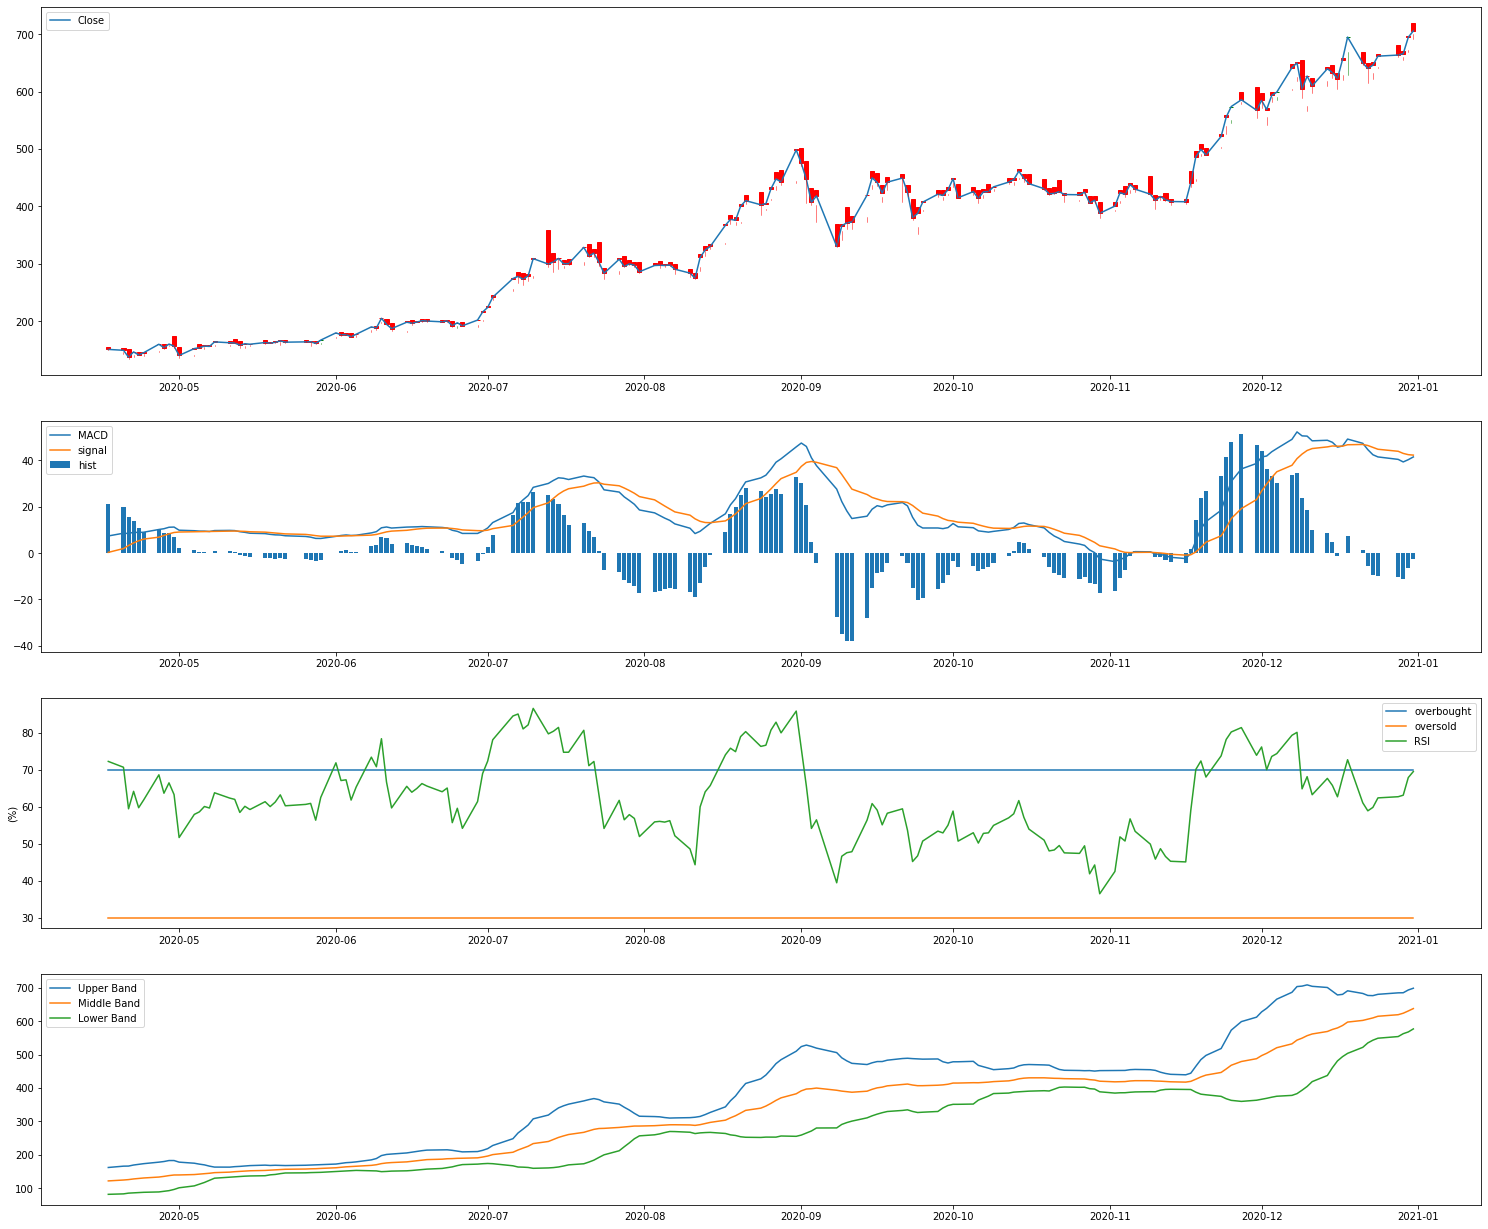

In [11]:
visualize(data,180,ticker)

In [12]:
driver=webdriver.Chrome(r'C:/Users/Aditya/chromedriver_win32/chromedriver')
driver.get('https://seekingalpha.com/symbol/{a}/analysis?from={b}&to={c}'.format(a=ticker,b=start_date,c=end_date))
time.sleep(4)
element=driver.find_element_by_tag_name('body')
last_height = driver.execute_script("return document.body.scrollHeight")
time.sleep(3)
while True:
            element.send_keys(Keys.END)
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height
elements = driver.find_elements_by_tag_name("article")        

In [13]:
result=[]
for element in elements:
        a,b=element.text.split('\n')
        c=b.replace('.','').split(',')
        print(c)
        if re.search('\w+Yesterday',c[0]):
            d=datetime.date.today()-datetime.timedelta(days=1)
        else:
            d=datetime.datetime.strptime(c[-2]+c[-1][:5],' %b %d %Y') if len(c)>=3 else datetime.datetime.strptime(c[1][:7]+str(datetime.date.today().year),' %b %d%Y')
        result.append((d,a))
    
df=pd.DataFrame(result,columns=['Date','News'])

['Invest To RetireTue', ' Dec 29', ' 2020643 Comments']
['Anton WahlmanSun', ' Dec 27', ' 2020807 Comments']
['Jonathan WeberThu', ' Dec 24', ' 2020372 Comments']
['Guy HooperThu', ' Dec 24', ' 2020386 Comments']
['Bill MaurerTue', ' Dec 22', ' 2020624 Comments']
["Editors' PickDaniel ShvartsmanTue", ' Dec 22', ' 2020101 Comments']
['Stuart AllsoppMon', ' Dec 21', ' 2020196 Comments']
["Editors' PickFishtown CapitalMon", ' Dec 21', ' 2020490 Comments']
['Steven FiorilloSat', ' Dec 19', ' 2020885 Comments']
['David TrainerFri', ' Dec 18', ' 2020700 Comments']
['Elazar Advisors', ' LLCFri', ' Dec 18', ' 2020179 Comments']
['Nick CoxTue', ' Dec 15', ' 2020469 Comments']
['John EngleTue', ' Dec 15', ' 2020243 Comments']
['Thurman DunnTue', ' Dec 15', ' 2020334 Comments']
['Jaberwock ResearchSun', ' Dec 13', ' 2020383 Comments']
['Chuck CarnevaleSat', ' Dec 12', ' 2020571 Comments']
['John EngleThu', ' Dec 10', ' 2020353 Comments']
['Elazar Advisors', ' LLCThu', ' Dec 10', ' 2020187 Comment

['Juan Carlos ZuletaWed', ' Jun 10', ' 2020130 Comments']
['Wolf RichterWed', ' Jun 10', ' 2020231 Comments']
['Ross TessienTue', ' Jun 09', ' 2020533 Comments']
['Bill MaurerTue', ' Jun 09', ' 2020292 Comments']
['Robert HoneywillTue', ' Jun 09', ' 202066 Comments']
['Bill MaurerMon', ' Jun 08', ' 2020307 Comments']
['Louis StevensThu', ' Jun 04', ' 2020171 Comments']
['Bill MaurerTue', ' Jun 02', ' 2020381 Comments']
["Editors' PickFishtown CapitalMon", ' Jun 01', ' 2020367 Comments']
['Anton WahlmanFri', ' May 29', ' 2020372 Comments']
['Keith WilliamsFri', ' May 29', ' 2020204 Comments']
['Philip DavisFri', ' May 29', ' 202017 Comments']
['Bill MaurerWed', ' May 27', ' 2020102 Comments']
['RD BarrisTue', ' May 26', ' 20201093 Comments']
['Montana SkepticTue', ' May 26', ' 2020289 Comments']
['Nick CoxThu', ' May 21', ' 2020263 Comments']
['Bill MaurerTue', ' May 19', ' 2020287 Comments']
['Doron LevinMon', ' May 18', ' 2020152 Comments']
['Montana SkepticSun', ' May 17', ' 2020443 

In [14]:
df.head()

,Date,News
0,2020-12-29,Tesla: I See Downgrades Ahead
1,2020-12-27,Not A Merry Christmas For Tesla In The Netherl...
2,2020-12-24,Apple Vs. Tesla: Self-Driving Car Showdown
3,2020-12-24,Tesla's Growth Is Not An Illusion: Its Strateg...
4,2020-12-22,Tesla: Slowly Losing Its First-Mover Advantage


In [15]:
df['News']=df.groupby('Date').transform(lambda x: ' '.join(x))
df=df.drop_duplicates()
df.reset_index(inplace=True,drop=True)
df

,Date,News
0,2020-12-29,Tesla: I See Downgrades Ahead
1,2020-12-27,Not A Merry Christmas For Tesla In The Netherl...
2,2020-12-24,Apple Vs. Tesla: Self-Driving Car Showdown Tes...
3,2020-12-22,Tesla: Slowly Losing Its First-Mover Advantage...
4,2020-12-21,3 Problems With Tesla's Valuation Tesla: Prepa...
...,...,...
184,2020-01-09,Tesla: Time For Capital Raise
185,2020-01-07,Tesla: There Is A Better Option To Invest Your...
186,2020-01-06,"Tesla At $451 A Share, Post 2019 Delivery Numb..."
187,2020-01-03,My Fearless Forecasts For Tesla's 2020


In [16]:
c=[]
ps=PorterStemmer()
for i in range(0,len(df['News'])):
    news=re.sub('[^a-zA-Z]',' ',df['News'][i])
    news=news.lower()
    news=news.split()
    news=[ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [17]:
df['News']=pd.Series(c)

In [18]:
df

,Date,News
0,2020-12-29,tesla see downgrad ahead
1,2020-12-27,merri christma tesla netherland
2,2020-12-24,appl vs tesla self drive car showdown tesla gr...
3,2020-12-22,tesla slowli lose first mover advantag last ca...
4,2020-12-21,problem tesla valuat tesla prepar signific drop
...,...,...
184,2020-01-09,tesla time capit rais
185,2020-01-07,tesla better option invest money address bulli...
186,2020-01-06,tesla share post deliveri number soft sell tes...
187,2020-01-03,fearless forecast tesla


In [19]:
sia=SentimentIntensityAnalyzer()
df['Compound']=[sia.polarity_scores(v)['compound'] for v in df['News']]
df['Negative']=[sia.polarity_scores(v)['neg'] for v in df['News']]
df['Neutral']=[sia.polarity_scores(v)['neu'] for v in df['News']]
df['Positive']=[sia.polarity_scores(v)['pos'] for v in df['News']]
df

,Date,News,Compound,Negative,Neutral,Positive
0,2020-12-29,tesla see downgrad ahead,0.0000,0.000,1.000,0.000
1,2020-12-27,merri christma tesla netherland,0.0000,0.000,1.000,0.000
2,2020-12-24,appl vs tesla self drive car showdown tesla gr...,0.7003,0.000,0.707,0.293
3,2020-12-22,tesla slowli lose first mover advantag last ca...,-0.4019,0.197,0.803,0.000
4,2020-12-21,problem tesla valuat tesla prepar signific drop,-0.5859,0.490,0.510,0.000
...,...,...,...,...,...,...
184,2020-01-09,tesla time capit rais,0.0000,0.000,1.000,0.000
185,2020-01-07,tesla better option invest money address bulli...,0.5719,0.134,0.535,0.332
186,2020-01-06,tesla share post deliveri number soft sell tes...,0.4215,0.097,0.612,0.291
187,2020-01-03,fearless forecast tesla,0.4404,0.000,0.408,0.592


Text(0, 0.5, 'Sentiment Scores')

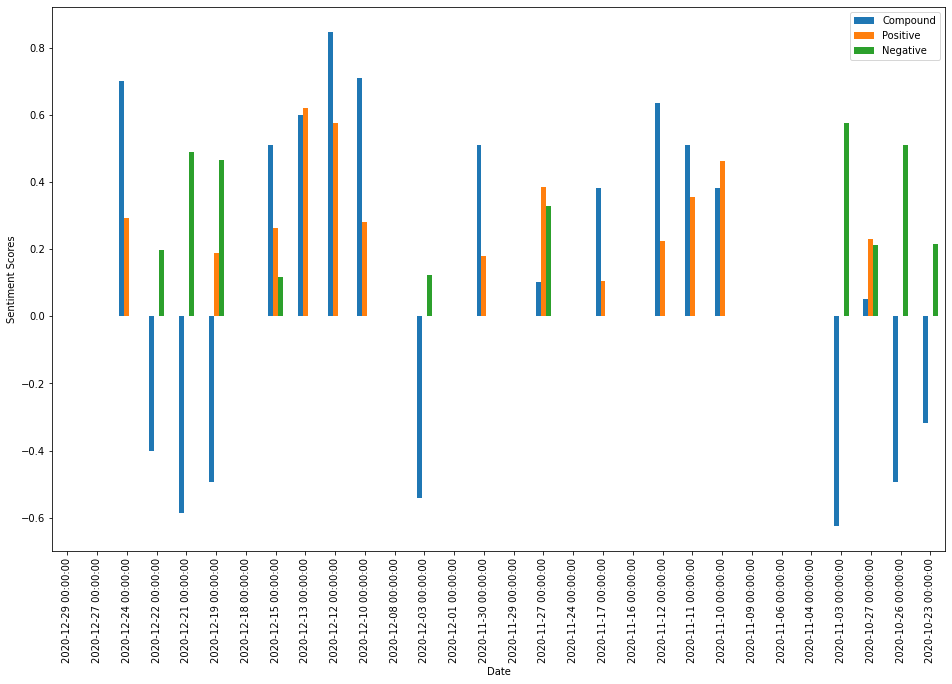

In [23]:
df[:30].plot(x='Date',y=['Compound','Positive','Negative'],kind='bar',figsize=(16,10))
plt.ylabel('Sentiment Scores')

In [24]:
data_merge=pd.merge(data,df,how='left',on='Date')
data_merge

,Date,High,Low,Open,Close,Volume,Adj Close,RSI,MACD,macd_signal,macd_hist,UPPER_BB,LOWER_BB,MIDDLE_BB,ROC,News,Compound,Negative,Neutral,Positive
0,2019-12-31,84.258003,80.416000,81.000000,83.666000,51428500.0,83.666000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,tesla ahead reduct ev tax incent netherland re...,0.0000,0.000,1.000,0.000
2,2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,fearless forecast tesla,0.4404,0.000,0.408,0.592
3,2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,tesla share post deliveri number soft sell tes...,0.4215,0.097,0.612,0.291
4,2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,tesla better option invest money address bulli...,0.5719,0.134,0.535,0.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2020-12-24,666.090027,641.000000,642.989990,661.770020,22865600.0,661.770020,62.428745,41.455905,44.759777,-3.303872,680.398281,548.939668,614.668975,1.829571,appl vs tesla self drive car showdown tesla gr...,0.7003,0.000,0.707,0.293
250,2020-12-28,681.400024,660.799988,674.510010,663.690002,32278600.0,663.690002,62.745666,40.396770,43.887176,-3.490406,684.809107,553.866181,619.337644,9.795200,NaN,NaN,NaN,NaN,NaN
251,2020-12-29,669.900024,655.000000,661.000000,665.989990,22910800.0,665.989990,63.151855,39.290076,42.967756,-3.677680,685.085098,562.476352,623.780725,6.206641,tesla see downgrad ahead,0.0000,0.000,1.000,0.000
252,2020-12-30,696.599976,668.359985,672.000000,694.780029,42846000.0,694.780029,67.927095,40.271899,42.428584,-2.156686,693.385921,567.699205,630.542563,13.900234,NaN,NaN,NaN,NaN,NaN


In [25]:
data_merge=data_merge.fillna(0)

<AxesSubplot:>

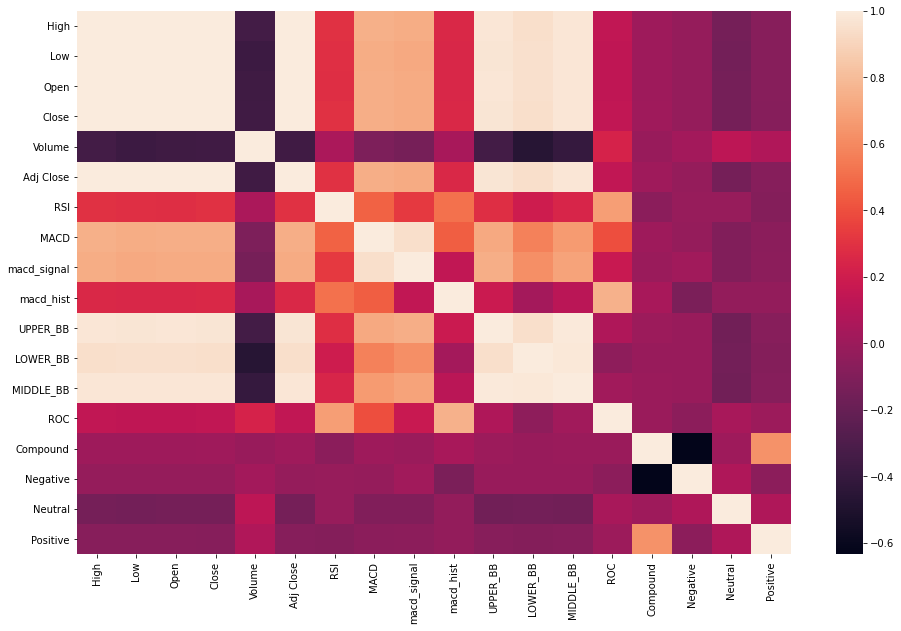

In [31]:
import seaborn as sns
plt.subplots(figsize=(16,10))
sns.heatmap(data_merge.corr())

In [27]:
data_merge=data_merge.drop(['News'],axis=1)

In [28]:
data_merge.set_index('Date')

,High,Low,Open,Close,Volume,Adj Close,RSI,MACD,macd_signal,macd_hist,UPPER_BB,LOWER_BB,MIDDLE_BB,ROC,Compound,Negative,Neutral,Positive
Date,,,,,,,,,,,,,,,,,,
2019-12-31,84.258003,80.416000,81.000000,83.666000,51428500.0,83.666000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,0.000,0.000
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,1.000,0.000
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.4404,0.000,0.408,0.592
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.4215,0.097,0.612,0.291
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5719,0.134,0.535,0.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,666.090027,641.000000,642.989990,661.770020,22865600.0,661.770020,62.428745,41.455905,44.759777,-3.303872,680.398281,548.939668,614.668975,1.829571,0.7003,0.000,0.707,0.293
2020-12-28,681.400024,660.799988,674.510010,663.690002,32278600.0,663.690002,62.745666,40.396770,43.887176,-3.490406,684.809107,553.866181,619.337644,9.795200,0.0000,0.000,0.000,0.000
2020-12-29,669.900024,655.000000,661.000000,665.989990,22910800.0,665.989990,63.151855,39.290076,42.967756,-3.677680,685.085098,562.476352,623.780725,6.206641,0.0000,0.000,1.000,0.000


In [29]:
dataframe=data_merge[['High','Low','Open','Close','Adj Close','RSI','MACD','UPPER_BB','LOWER_BB','MIDDLE_BB','ROC','Compound','Negative','Neutral','Positive']]
dataframe

,High,Low,Open,Close,Adj Close,RSI,MACD,UPPER_BB,LOWER_BB,MIDDLE_BB,ROC,Compound,Negative,Neutral,Positive
0,84.258003,80.416000,81.000000,83.666000,83.666000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,0.000,0.000
1,86.139999,84.342003,84.900002,86.052002,86.052002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000,1.000,0.000
2,90.800003,87.384003,88.099998,88.601997,88.601997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.4404,0.000,0.408,0.592
3,90.311996,88.000000,88.094002,90.307999,90.307999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.4215,0.097,0.612,0.291
4,94.325996,90.671997,92.279999,93.811996,93.811996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5719,0.134,0.535,0.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,666.090027,641.000000,642.989990,661.770020,661.770020,62.428745,41.455905,680.398281,548.939668,614.668975,1.829571,0.7003,0.000,0.707,0.293
250,681.400024,660.799988,674.510010,663.690002,663.690002,62.745666,40.396770,684.809107,553.866181,619.337644,9.795200,0.0000,0.000,0.000,0.000
251,669.900024,655.000000,661.000000,665.989990,665.989990,63.151855,39.290076,685.085098,562.476352,623.780725,6.206641,0.0000,0.000,1.000,0.000
252,696.599976,668.359985,672.000000,694.780029,694.780029,67.927095,40.271899,693.385921,567.699205,630.542563,13.900234,0.0000,0.000,0.000,0.000


In [32]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(dataframe))
new_df.columns = dataframe.columns
new_df.index = dataframe.index
new_df.head()

,High,Low,Open,Close,Adj Close,RSI,MACD,UPPER_BB,LOWER_BB,MIDDLE_BB,ROC,Compound,Negative,Neutral,Positive
0,0.005153,0.016608,0.009695,0.018032,0.018032,0.0,0.22925,0.0,0.0,0.0,0.414125,0.528190,0.00000,0.000,0.000000
1,0.008104,0.022930,0.015935,0.021799,0.021799,0.0,0.22925,0.0,0.0,0.0,0.414125,0.528190,0.00000,1.000,0.000000
2,0.015410,0.027829,0.021054,0.025825,0.025825,0.0,0.22925,0.0,0.0,0.0,0.414125,0.782330,0.00000,0.408,0.880952
3,0.014645,0.028820,0.021045,0.028518,0.028518,0.0,0.22925,0.0,0.0,0.0,0.414125,0.771424,0.12125,0.612,0.433036
4,0.020939,0.033123,0.027742,0.034050,0.034050,0.0,0.22925,0.0,0.0,0.0,0.414125,0.858215,0.16750,0.535,0.494048


In [33]:
X=dataframe.drop('Adj Close',axis=1)
y=dataframe['Adj Close']

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [35]:
X_train.shape

(203, 14)

In [36]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
prediction=rf.predict(X_test)

In [37]:
print(prediction[:10])
print(y_test[:10])
from sklearn.metrics import mean_squared_error
print(mean_squared_error(prediction,y_test))

[346.30451813 160.46364059 452.89841675 163.13900223 296.20511261
 451.70029968 199.66574234 549.06168854  98.32579941 309.2999176 ]
158    367.127991
83     156.376007
170    447.369995
101    164.046005
150    297.003998
200    448.880005
118    200.179993
228    555.380005
63      96.311996
135    309.201996
Name: Adj Close, dtype: float64
51.66278505905561


In [38]:
adb = AdaBoostRegressor()
adb.fit(X_train, y_train)
predictions = adb.predict(X_test)

print(mean_squared_error(predictions, y_test))

388.95939781772586


In [41]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(X_train, y_train)
predictions = dec_tree.predict(X_test)
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[318.46600342 156.00799561 448.16000366 163.88400269 290.54199219
 448.16000366 200.79200745 521.84997559 101.         310.95199585]
158    367.127991
83     156.376007
170    447.369995
101    164.046005
150    297.003998
200    448.880005
118    200.179993
228    555.380005
63      96.311996
135    309.201996
Name: Adj Close, dtype: float64
129.8185001649944


In [39]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(X_train, y_train)
predictions = lgb.predict(X_test)
print(mean_squared_error(predictions,y_test))

164.83526980821406


In [40]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
print(mean_squared_error(predictions,y_test))

85.46264602536878
